#### imports

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd

In [2]:
##### Segmentation model
from transformers import pipeline
pipe = pipeline("image-segmentation", model="briaai/RMBG-1.4", trust_remote_code=True)

/media/pixis/pixis/tausif_workspace/miniconda3/envs/any/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

# Utility functions

def initialize_video_capture(video_file_path):
    vc = cv2.VideoCapture(video_file_path)
    ret, first_frame = vc.read()
    if not ret:
        raise ValueError("Error: Could not read the first frame.")
    return vc, first_frame

def initialize_video_writer(vc, final_path, frame_size):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = vc.get(cv2.CAP_PROP_FPS)
    out = cv2.VideoWriter(final_path, fourcc, fps, frame_size)
    if not out.isOpened():
        raise ValueError("Error: VideoWriter did not open.")
    return out

def get_segmented_gray_frame(frame, resize_dim):
    image_pil = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image_pil)
    pillow_image = pipe(image_pil)  # applies mask on input and returns a pillow image
    image_np = np.array(pillow_image)
    frame_cv2 = image_np[:, :, ::-1]
    seg_gray = cv2.cvtColor(frame_cv2, cv2.COLOR_BGR2GRAY)
    seg_gray = cv2.resize(seg_gray, (resize_dim[0], resize_dim[1]))
    return seg_gray

def initialize_display(resize_dim):
    plt.ion()
    fig, ax = plt.subplots()
    img_display = ax.imshow(np.zeros((resize_dim[0], resize_dim[1], 3), dtype=np.uint8))
    plt.title("Dense Optical Flow")
    return fig, ax, img_display

def calculate_optical_flow_magnitude(prev_gray, seg_gray):
    # Lucas-Kanade parameters
    lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    # Find the initial points
    p0 = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
    # Calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(prev_gray, seg_gray, p0, None, **lk_params)
    # Select good points
    good_new = p1[st == 1]
    good_old = p0[st == 1]

    # Initialize flow with zeros
    flow = np.zeros((prev_gray.shape[0], prev_gray.shape[1], 2), dtype=np.float32)
    for (new, old) in zip(good_new, good_old):
        a, b = new.ravel()
        c, d = old.ravel()
        if 0 <= int(b) < flow.shape[0] and 0 <= int(a) < flow.shape[1]:
            flow[int(b), int(a), 0] = a - c
            flow[int(b), int(a), 1] = b - d
    
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    return magnitude, angle



def create_dense_flow_visual(frame, magnitude, angle, mask):
    mask[..., 0] = angle * 180 / np.pi / 2
    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
    dense_flow = cv2.addWeighted(frame, 1, rgb, 2, 0)
    return dense_flow

def update_display(img_display, dense_flow):
    img_display.set_data(cv2.cvtColor(dense_flow, cv2.COLOR_BGR2RGB))
    plt.pause(0.001)

def save_frame(out, dense_flow):
    out.write(dense_flow)

def release_resources(vc, out, fig):
    vc.release()
    out.release()
    plt.ioff()
    plt.close(fig)


In [4]:
DEBUGER = False
resize_dim = 600
THRESH_MAGN = 100
# Global variables
vid_save_path = "./butterworth-filtered-videos/optical-flow-vids_lk"

def ensure_directory_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

ensure_directory_exists(vid_save_path)

In [7]:

def process_video(video_file_path):
    valid_movement = True
    max_magnitude = 0
    frame_counter = 0
    fname = video_file_path.split("/")[-1]

    avg_magnitudes = []
    avg_angles = []
    max_magnitudes = []

    final_path = os.path.join(vid_save_path, fname)

    vc, first_frame = initialize_video_capture(video_file_path)
    H, W, c = first_frame.shape
    width, height = W // 3, H // 3

    first_frame_resized = cv2.resize(first_frame, (width, height))
    prev_gray = get_segmented_gray_frame(first_frame_resized, (width, height))

    mask = np.zeros_like(first_frame_resized)
    mask[..., 1] = 255

    '''Debugging purposes'''
    if DEBUGER:
        out = initialize_video_writer(vc, final_path, (width, height))
        fig, ax, img_display = initialize_display((width, height))

    while vc.isOpened():
        frame_counter += 1
        ret, frame = vc.read()
        
        if not ret:
            break
        
        frame_resized = cv2.resize(frame, (width, height))
        seg_gray = get_segmented_gray_frame(frame_resized, (width, height))

        magnitude, angle = calculate_optical_flow_magnitude(prev_gray, seg_gray)

        if np.any(np.isinf(magnitude)) or np.any(np.isnan(magnitude)):
            valid_movement = False
        
        if DEBUGER:
            dense_flow = create_dense_flow_visual(frame_resized, magnitude, angle, mask)
            update_display(img_display, dense_flow)
            save_frame(out, dense_flow)

        max_magnitude_temp = np.max(magnitude)
        if max_magnitude_temp > THRESH_MAGN:
            valid_movement = False
            max_magnitude = max_magnitude_temp
        else:
            max_magnitude = max(max_magnitude, max_magnitude_temp)

        avg_magnitude = np.mean(magnitude)
        avg_angle = np.mean(angle)

        avg_magnitudes.append(avg_magnitude)
        avg_angles.append(avg_angle)
        max_magnitudes.append(max_magnitude_temp)

        prev_gray = seg_gray.copy()

    if DEBUGER:    
        release_resources(vc, out, fig)

    avg_magnitudes = np.array(avg_magnitudes)
    avg_angles = np.array(avg_angles)
    max_magnitudes = np.array(max_magnitudes)

    return max_magnitude, valid_movement, max_magnitudes, avg_angles, avg_magnitudes



In [9]:

max_magnitude, valid_movement, max_magnitudes, avg_angles, avg_magnitudes  = process_video('./butterworth-filtered-videos/all_dataset/85f4265d-855_video_M_mat_butter_low_pass.mp4')
print(f"Max magnitude: {max_magnitude}, Valid movement: {valid_movement}")


Max magnitude: 2.5091516971588135, Valid movement: True


In [10]:
video_analysis_df = pd.DataFrame({})

def get_abs_vid_file_paths(root_dir):
    all_files = []
    
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if "video_M_mat_butter_low_pass.mp4" in filename:
                all_files.append(os.path.join(dirpath, filename))
    return all_files

vid_file_list = get_abs_vid_file_paths("./butterworth-filtered-videos/all_dataset")


##### Single Thread
# for video_file_path in vid_file_list:
#         max_magnitude, valid_movement = process_video(video_file_path)
#         result_dict = {
#                 "video_file_path" : video_file_path,
#                 "valid_movement" : valid_movement,
#                 "max_magnitude" : max_magnitude
#                 }
#         row = pd.DataFrame(result_dict, index = [0])
#         video_analysis_df = pd.concat([video_analysis_df, row])

In [11]:
from tqdm import tqdm


def analyze_video(video_file_path):
    max_magnitude, valid_movement, max_magnitudes, avg_angles, avg_magnitudes = process_video(video_file_path)
    return {
        "video_file_path": video_file_path,
        "valid_movement": valid_movement,
        "max_magnitude": max_magnitude,
        "max_magnitudes_per_frame": max_magnitudes, 
        "avg_angle_per_frame" : avg_angles, 
        "avg_magnitude_per_frame" : avg_magnitudes
    }

##### Single Thread
# for video_file_path in tqdm(vid_file_list):
#     result_dict = analyze_video(video_file_path)
#     row = pd.DataFrame(result_dict, index=[0])
#     video_analysis_df = pd.concat([video_analysis_df, row], ignore_index=True)


#### ThreadPools
with ThreadPoolExecutor(max_workers=3) as executor:
    futures = {executor.submit(analyze_video, video_file_path): video_file_path for video_file_path in vid_file_list}
    for future in tqdm(as_completed(futures), total=len(futures)):
        result_dict = future.result()
        row = pd.DataFrame(result_dict)
        video_analysis_df = pd.concat([video_analysis_df, row], ignore_index=True)
# 
# Now video_analysis_df contains the results of all processed videos


100%|██████████| 315/315 [1:48:13<00:00, 20.61s/it]  


In [12]:
video_analysis_df.to_csv("./saved-dfs/lucas-kanade-method.csv")

In [13]:
video_analysis_df.dtypes['max_magnitude'] 

dtype('float32')

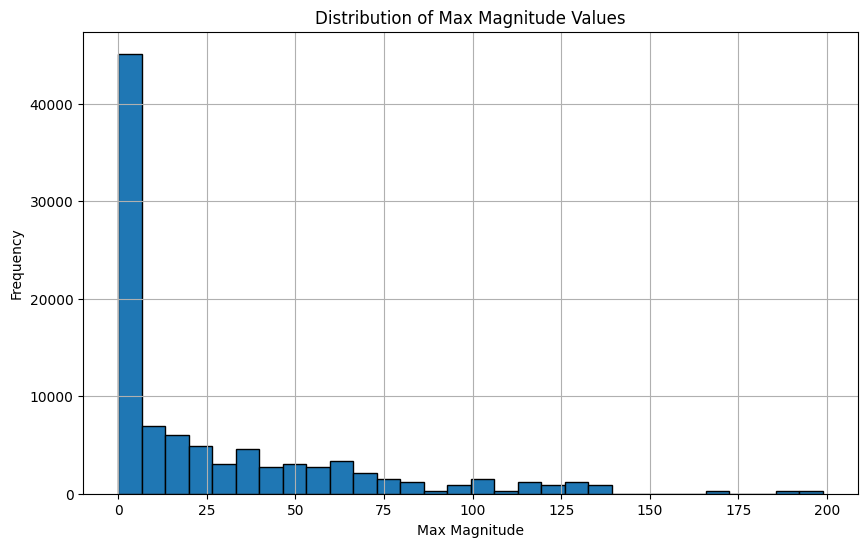

In [15]:
import matplotlib.pyplot as plt

# Get the distribution of max magnitude of movement.
# Extract max_magnitude values
max_magnitude_values = video_analysis_df["max_magnitude"].values

# Plot the histogram
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(max_magnitude_values, bins=30, edgecolor='black')
plt.title("Distribution of Max Magnitude Values")
plt.xlabel("Max Magnitude")
plt.ylabel("Frequency")
plt.grid(True)

# # Add counts on top of the bars
# for i in range(len(patches)):
#     plt.text(patches[i].get_x() + patches[i].get_width() / 2, patches[i].get_height(), 
#              str(int(n[i])), ha='center', va='bottom')

plt.show()

In [29]:
THRESH_MAGN = 60
filtered_df = video_analysis_df[video_analysis_df["max_magnitude"] > float(THRESH_MAGN)]
filtered_df.shape

(41, 3)

In [30]:
import shutil
no_vid_files = []


for index, row in filtered_df.iterrows():
    vid_path = dict(row)["video_file_path"]
    fname = vid_path.split("/")[-1]
    sub_folder = "./butterworth-filtered-videos/exceeds_thresholds"
    final_path = os.path.join(sub_folder, fname)

    if not os.path.exists(vid_path):
        no_vid_files.append(vid_path)
    
    shutil.copy(vid_path, final_path)

### misce : Copy required dataset 

In [5]:
import uuid
import shutil

In [6]:
def get_abs_file_paths(root_dir):
    all_files = []
    
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith(".jpg") and "frame_" in filename:
                all_files.append(os.path.join(dirpath, filename))
    return all_files

def copy_to_dest(src_path, dest):
    idx = str(uuid.uuid4())
    file_name = src_path.split("/")[-1]
    destination_path = os.path.join(dest, idx[:12] + "_" + file_name)
    shutil.copy(src_path, destination_path)


In [7]:
root_dir = "../Data/"
test_sample_paths = get_abs_file_paths(root_dir)

In [17]:
# dest = "./org_frames_dataset/"
# for src in test_sample_paths:
#     copy_to_dest(src, dest)


### Copy all the video files to 

In [10]:
def get_abs_vid_file_paths(root_dir):
    all_files = []
    
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if "video_M_mat_butter_low_pass.mp4" in filename:
                all_files.append(os.path.join(dirpath, filename))
    return all_files

video_files = get_abs_vid_file_paths(root_dir)

# vid_dest = "./butterworth-filtered-videos/all_dataset"
# for files in video_files:
#     copy_to_dest(files, vid_dest)